In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt

In [2]:
# Reading the input file
prime = pd.read_csv("3' UTR DENV1 DF + DHF.csv", header=None)

# Printing the shape of the data
print("The shape of 3' data is:", str(prime.shape))

The shape of 3' data is: (21, 2)


In [3]:
# Making the disease label column
severity = []
for disease in prime[0]:
    if disease == "DF":
        severity.append(0)
    elif disease == "DHF":
        severity.append(1)
    else:
        continue

dengue = pd.DataFrame(columns = ["Sequence", "Disease"])
dengue["Sequence"] = prime[1]
dengue["Disease"] = severity

dengue = dengue.sample(frac = 1)

print(dengue.head())

                     Sequence  Disease
4   UCAACUUCAAUGAUAAGAACGGAGA        1
20  CCAACUCUGAUGAUAGAAACAAAGU        1
1   UCAACUUCAAUGACAAGAACGGAGA        0
3   CUAAUUUCAAUGAUAAGAUCGGAGA        1
8   CCACUCCCACCAAUGAAAACGGAGA        0


In [4]:
# Function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size = 6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

dengue['words'] = dengue.apply(lambda x: getKmers(x['Sequence']), axis=1)
dengue = dengue.drop('Sequence', axis=1)

dengue_texts = list(dengue['words'])
for item in range(len(dengue_texts)):
    dengue_texts[item] = ' '.join(dengue_texts[item])

The shape of y is: (21,)


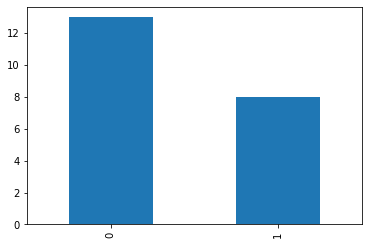

In [5]:
# Creating y and printing the shape of it
y = dengue.iloc[:, 0].values
print("The shape of y is:", y.shape)

# Checking the balance of the disease severity
dengue["Disease"].value_counts().sort_index().plot.bar()

In [6]:
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
x = cv.fit_transform(dengue_texts)

# Print the shape of x
print("The shape of x matrix is:", x.shape)

The shape of x matrix is: (21, 123)


In [7]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42)

# Printing the shapes of the train and test matrices
print("The shape of x_train is:", X_train.shape)
print("The shape of y_train is:", y_train.shape)
print("The shape of x_test is:", X_test.shape)
print("The shape of y_test is:", y_test.shape)

The shape of x_train is: (16, 123)
The shape of y_train is: (16,)
The shape of x_test is: (5, 123)
The shape of y_test is: (5,)


## Random Forest

In [8]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 9, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Making a prediction of the test set sequences
y_pred = classifier.predict(X_test)

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))

def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

print('')

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = {} \nprecision = {} \nrecall = {} \nf1 = {}".format(accuracy, precision, recall, f1))

Confusion matrix

Predicted  0  1
Actual         
0          3  0
1          1  1

accuracy = 0.8 
precision = 0.85 
recall = 0.8 
f1 = 0.7809523809523808
